In [1]:
using LinearAlgebra,Polynomials,Printf,Random,ForwardDiff,PyPlot,PyCall,FFTW,Zygote,Optim,LaTeXStrings,FiniteDifferences

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


In [2]:
np=pyimport("numpy")

PyObject <module 'numpy' from 'C:\\Users\\bryan\\.julia\\Conda_env\\lib\\site-packages\\numpy\\__init__.py'>

## ARC Functions

In [9]:
function ARCSubproblem(gx,B,v1,lambda1,sigma,kappa_easy,subMaxIts)
# Usage: p = ARCSubproblem(gx,B,v1,lambda1,sigma,kappa_easy,maxIts)
#adapted from Algorithm 7.3.6, Conn et al 2000, Algorithm 4.3, Nocedal
#and Wright, 2006, and Cartis et al 2011

#subout returns -1 if Hessian is ill-conditioned, 0 if maxIts is reached, 1
#if a good solution is found, 2 if an edge case is reached

lambda = max(0,-lambda1)
#small value to resolve numerical instability from eig and chol
if lambda != 0 #strictly greater than
    lambda = lambda + eps(lambda)
end
Delta = lambda/sigma

B1=deepcopy(B)

i=0

#we are trying to find the global minimizer of m(p). It should satisfy
#1. (B+lambda*I)p = -g
#2. lambda^2 = sigma^2*norm(p)
#see Eqn (6.1) in Cartis et al 2011
while true
    i=i+1
    #increment diagonal more efficiently than whole-matrix addition
    B1[1:1+size(B1,1):end] = diag(B).+lambda
    C = cholesky(B1,check=false)
    flag = LinearAlgebra.issuccess(C)
    k = 0
    lambda_const = eps(lambda)
    #fail to be positive definite
    while flag == 0
        k = k+1
        B1[1:1+size(B1,1):end] = diag(B1).+lambda_const
        C = cholesky(B1,check=false)
        flag = LinearAlgebra.issuccess(C)
        # gradually increase the constant to reduce iterations
        lambda_const = min(lambda_const*2,abs(lambda1))
        if k > subMaxIts
            p = zeros(size(gx))
            # -1 = failed to find cholesky
            return p,(info=-1,iter=i)
        end
    end
    p = -C.U\(C.L\gx)
    normp = norm(p)
    if i == subMaxIts
        # 0 = maxIts reached
        return p,(info=0,iter=i)
    end
    if abs(normp-Delta) < kappa_easy
        # 1 = good solution found
        return p,(info=1,iter=i)
    end
    if normp <= Delta
        if lambda == 0 || normp == Delta
            # 2 = edge case
            return p,(info=2,iter=i)
        else #"hard case", Nocedal and Wright, 2006 P88 Equation 4.45
            #%also see Algorithm 7.3.6, P199 of Conn 2000
            #fprintf('A wild "hard case" appeared!\n');
            #1*tau^2+0*tau+(norm^2-Delta^2)=0
            #normp is the same as the expression cuz the first eigenvector
            #dot gx is zero
            #hp = [1 0 norm(V(:,2:end)'*gx./(evals(2:end)+lambda))^2-Delta^2];
            # find the larger root of the quadratic equation
            tau = maximum(roots(Polynomial([1,0,normp^2-Delta^2])))
            p = tau*v1 + p
        end
    end
    q = C.L\p
    if lambda < eps(lambda)
        lambda = lambda + lambda_const
    else
        #Newton method to update lambda, simplified version of phi(lambda)/phi'(lambda) eqn (6.7) and (6.10) in Nocedal
        #and Wright
        lambda = lambda + lambda*(normp-Delta)/(normp+Delta*lambda*(norm(q)/normp)^2)
    end
    Delta = lambda/sigma
end
end

#output structs
mutable struct Output
    errHistory::Array{Float64,1}
    gradnorm::Array{Float64,1}
    xnorm::Array{Float64,1}
    sigma::Array{Float64,1}
    rho::Array{Float64,1}
    info::Int
    iter::Int
    subout::Array{NamedTuple,1}
end
"""
#forcing AD hessian to be Zygote only didn't work
function my_jacobian(f, x::AbstractArray)
    y, back  = Zygote.pullback(vec∘f, x)
    k, n = length(y), length(x)
    e_array = Matrix(I,k,k)
    slices = map(1:k) do i
        b = back(e_array[:,i])[1]
        b===nothing ? falses(n) : vec(b)
    end
    (reduce(hcat, slices),)
end
my_hessian(f, x::AbstractArray) = my_jacobian(x -> Zygote.gradient(f, x)[1], x)[1]
"""
function symmetricADHessian(f,x)
    Hx = Zygote.hessian(f,x)
    #Hx = my_hessian(f,x)
    return LinearAlgebra.tril(Hx,-1)+LinearAlgebra.tril(Hx)'
end


function cubicReg(f,x;grad=x->Zygote.gradient(f,x),H=x->symmetricADHessian(f,x),errFcn=x->f(x), errTol=1e-10,maxIts=1e4,subMaxIts=500,sigma=1,sigma_min=1e-3,eta1=0.1,eta2=0.9,kappa_easy=1e-4)

    #m-function to compute rho
    m(p,gx,Hx,sigma) = dot(p,gx) + 0.5 * dot(Hx*p,p) + 1/3*sigma*norm(p)^3
    fx = f(x)
    gx = grad(x)

    out = Output([],[],[],[],[],-9,-9,[])
    push!(out.errHistory,errFcn(x))
    push!(out.gradnorm,norm(gx))
    push!(out.xnorm,norm(x))

    Hx = H(x)
    E = eigen(Hx)
    #leftmost eigenvalue/vector
    v1 = E.vectors[:,1]
    lambda1 = E.values[1]
    i=0
    while true
        i=i+1
        push!(out.sigma,sigma)
        p,subout = ARCSubproblem(gx,Hx,v1,lambda1,sigma,kappa_easy,subMaxIts)
        push!(out.subout,subout)
        #failed cholesky, terminate
        if subout.info == -1
            out.info = -1;
            out.iter = i-1;
            return x,out
        end
        rho = (fx-f(x+p))/(-m(p,gx,Hx,sigma))
        push!(out.rho,rho)
        #reach maxIts
        if i == maxIts
            out.info  = 0
            out.iter = maxIts
            return x,out
        end
        if rho >= eta1
            x = x + p
            #@printf "norm(x)=%f\n" norm(x)
            fx = f(x)
            gx = grad(x)
            #stopping-criteria reached
            if abs(fx) < errTol
                push!(out.errHistory,errFcn(x))
                push!(out.gradnorm,norm(gx))
                push!(out.xnorm,norm(x))
                out.iter = i
                out.info = 1
                return x,out
            end
            #only compute the next Hessian and eig if necessary
            Hx = H(x);
            E = eigen(Hx)
            v1 = E.vectors[:,1]
            lambda1 = E.values[1]
            #if very successful, expand TR radius
            if rho > eta2
               sigma = max(0.5 * sigma,sigma_min)
            end
        #unsuccessful, shrink TR radius and reuse other variables
        else
            sigma = 2 * sigma
        end
        push!(out.errHistory,errFcn(x))
        push!(out.gradnorm,norm(gx))
        push!(out.xnorm,norm(x))
    end
end


cubicReg (generic function with 1 method)

## Optic Functions

In [118]:
function make_prop_kernel( sz, z; dl=2,lmbd=0.5)
    nx = sz[1]
    ny = sz[2]
    k=2*pi/lmbd # wavenumber
    dkx=2*pi/((nx-1)*dl)
    dky=2*pi/((ny-1)*dl)
    kx=(LinRange(0,nx-1,nx).-nx/2)*dkx
    ky=(LinRange(0,ny-1,ny).-ny/2)*dky

    inflate(f, kx, ky) = [f(x,y) for x in kx, y in ky]
    f(kx,ky)=exp(1im*sqrt(k^2-kx^2-ky^2)*z)

    prop_kernel=inflate(f,kx,ky)

    prop_kernel = ifftshift(prop_kernel)
    
    return prop_kernel
end

function light_prop(e_in, prop_kernel,pfft,pifft)
    #if ndims(e_in) == 3
     #   prop_kernel = reshape(prop_kernel,(1,size(prop_kernel)...))
    #end
    ek_in  = pfft*ifftshift(e_in)
    ek_out = ek_in.*prop_kernel
    e_out  = fftshift(pifft.scale.*(pifft.p*ek_out)) #Zygote can't handle pifft directly
    return e_out
end

function phase_mod(e_in, theta; samp_ratio=1)
    #=
    e_in is the input field
    theta is the phase mask
    samp_ratio is the pixel size ratio between the phase mask and the e field 
    =#
    if ndims(e_in) == 2
        if samp_ratio == 1
            e_out = e_in.*exp.(1im*theta)
        else
            e_out = e_in.*kron(exp.(1im*theta),ones((samp_ratio,samp_ratio)))
        end
    elseif ndims(e_in) == 3
        if samp_ratio == 1
            M = exp.(1im*theta)
            #e_out = e_in.*reshape(M,(1,size(M)...))
            e_out = e_in.*M
        else
            M = kron(exp.(1im*theta),ones((samp_ratio,samp_ratio)))
            #e_out = e_in.*reshape(M,(1,size(M)...))
            e_out = e_in.*M
        end
    end
    return e_out
end

#forward propagation
function propagatedOutput(e_in,airKernels,theta,pfft,pifft)
    e_out = e_in
    for jj = 1:size(theta,3)  # loop over plate
        e_out = light_prop(e_out, airKernels[:,:,jj],pfft,pifft)
        e_out = phase_mod(e_out, theta[:,:,jj], samp_ratio=1)
    end
    return e_out
end

function L(input,airKernels,e_in_post,theta,j,pfft,pifft)
    #e_in_post is the e_in after the first air propagation. It is constant so we can precompute and save time.
    output = e_in_post .* reshape(input,size(e_in_post)[1:2])
    for ii = 1:size(theta,3)  # loop over plate
        if ii == j
            output = light_prop(output, airKernels[:,:,ii+1],pfft,pifft)
        else
            output = phase_mod(output, theta[:,:,ii], samp_ratio=1)
            output = light_prop(output, airKernels[:,:,ii+1],pfft,pifft)
        end
    end
    return output
end
function L_star(input,airKernels,e_in_post,theta,j,pfft,pifft)
    #e_in_post is the e_in after the first air propagation. It is constant so we can precompute and save time.
    output = input
    for ii = size(theta,3):-1:1  # loop over plate
        if ii == j
            output = light_prop(output, airKernels[:,:,ii+1],pfft,pifft)
        else
            output = light_prop(output, airKernels[:,:,ii+1],pfft,pifft)
            output = phase_mod(output, theta[:,:,ii], samp_ratio=1)
        end
    end
    return vec(sum(e_in_post.*output,dims=3))
end

L_star (generic function with 1 method)

## main()

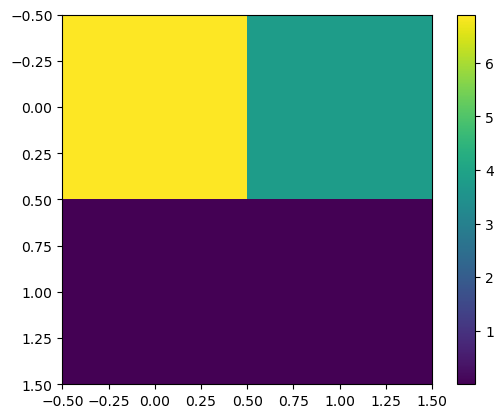

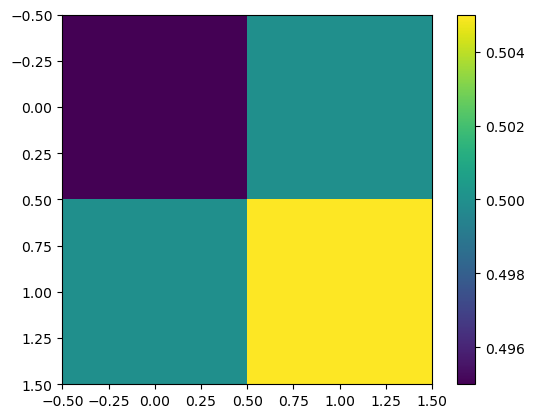

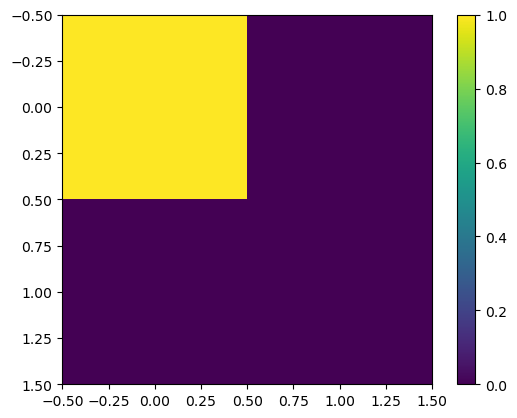

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000060BF8D90>

In [111]:
#reducing pixels resulted in very strange looking desired output
nx = 2
ny = 2
npl = 5


# wavelength
lmbd = 0.5 # in um
# pixel size
dl = 5 # unit um

x=(LinRange(0,nx-1,nx).-nx/2)*dl
y=(LinRange(0,ny-1,ny).-ny/2)*dl

#no idea what this is doing, is s_input the coordinate to create Gaussian spots?
s_input = Matrix(undef,sum(1:npl-1),2)
p = 25 # pitch
k=0
for  ii =1:npl-1
    ys = -ii*p*sqrt(2)/2
    for jj =0:ii-1
        k+=1
        xs = ys + jj*p*sqrt(2)
        s_input[k,:]=[xs,ys]
    end
end

nmod = size(s_input,1)
e_in = zeros(ny,nx,nmod)#why ny nx?
w_in = 6# beam width
inflate(f, x, y, i) = [f(xx,yy,i) for xx in x, yy in y]
#Gaussian
f(x,y,i)=exp(-((x-s_input[i,1])^2+(y-s_input[i,2])^2)/w_in^2)
for ii = 1:nmod
    e = inflate(f,x,y,ii)
    I = sum(abs2,e)
    e_in[:,:,ii] = e'/sqrt(I) #normalize, x,y very confusing!!!
end

#precompute the plan to avoid AD the plan function
pfft = plan_fft(e_in)
pifft = plan_ifft(e_in)

fig, ax = plt.subplots()
image=ax.imshow(dropdims(sum(e_in, dims=3),dims=3))
cbar=plt.colorbar(image)  

# output
e_target = zeros(ny, nx, nmod) #why ny nx?
w_target = 50
inflate(f, x, y) = [f(xx,yy) for xx in x, yy in y]
f(x,y)=exp(-(x^2+y^2)/w_target^2)
M = inflate(f,x,y)

for  ii = 1:npl-1
    for jj = 1:ii
        c = zeros(jj,ii-jj+1)
        c[jj,ii-jj+1]=1
        #only get the last term?
        e = np.polynomial.hermite.hermgrid2d(sqrt(2)*x/w_target, sqrt(2)*y/w_target, c).*M
        I = sum(abs2,e)
        kk = fld(ii*(ii-1),2)+jj# list index (it's actually just 1:10)
        e_target[:,:,kk] = e/sqrt(I)
    end
end

fig, ax = subplots()
image=ax.imshow(e_target[:,:,1])
cbar=colorbar(image)
fig, ax = subplots()
image=ax.imshow(e_target[:,:,5])
cbar=colorbar(image)

In [112]:
d = [2e4,2.5e4,2.5e4,2.5e4,2.5e4,2e4]
#air propagtion is a constant linear operator so we can precompute it
airKernels   = zeros(ComplexF64,(nx,ny,npl+1))
for jj = 1:npl+1
  airKernels[:,:,jj] = make_prop_kernel( (nx,ny), d[jj],dl=dl,lmbd=lmbd)
end

## Objective Function

In [113]:
#sum of frobenius norm squared is the same as frobenius norm of the 3D array squared
mat(x) = reshape(x,(nx,ny,npl))
f(x)=1/2*norm(propagatedOutput(e_in,airKernels,mat(x),pfft,pifft)-e_target)^2

function grad_f(x,mat,airKernels,e_in_post,e_target,pfft,pifft)
    g(x)=exp.(x.*im)
    X = mat(x)
    grad = zeros(size(X)[1]*size(X)[2],size(X)[3])
    for j = 1:size(X,3)
        xj = X[:,:,j]
        g_xj = g(xj)
        input = L(g_xj.*xj,airKernels,e_in_post,X,j,pfft,pifft)-(e_target.+0im)
        grad[:,j] = real(L_star(input,airKernels,e_in_post,X,j,pfft,pifft))
    end
    return vec(grad)
end

grad_f (generic function with 3 methods)

In [120]:
e_in_post = light_prop(e_in, airKernels[:,:,1],pfft,pifft)
x0=randn(npl*nx*ny)
f(x0)

10.724133849233237

In [121]:
grad_f(x0,mat,airKernels,e_in_post,e_target,pfft,pifft)

20-element Array{Float64,1}:
  0.09191176097456658
  0.4034771106692939
 -0.05651061572900171
 -3.687056509482018
  0.019978277401891543
  0.9719335585066264
 -0.03806133744886977
  0.7831921065544429
 -0.05691211918151598
 -0.901424934253962
  0.05153621227764095
  1.2184891791744399
  0.016111472704205446
 -0.25331698156768756
 -0.1125380092215704
 -3.4058590806567888
  0.04323717709737396
 -0.8302350758590897
  0.013119598290727265
 -2.5534437420237213

In [122]:
grad(central_fdm(5, 1), f, x0)[1]

20-element Array{Float64,1}:
  0.002350506478545753
 -0.005688220333244371
 -0.004458211500758821
 -0.8014192121720961
 -0.3193079241866048
 -0.09471242750793646
 -0.6796164965241074
  0.28442171068992483
  0.328078874050806
  0.1229040382421372
 -0.74314138375807
 -0.5170566660590517
  0.3461584680075043
 -0.1020225999000366
 -0.3925593432582437
 -0.6607916623760001
 -0.6401116087515475
 -0.22742851636259256
  0.11967742101413807
 -0.06135243342744801

In [72]:
L"""
Let $\mathcal{Y}$ be the $10$ by $n_x$ by $n_y$ output of forward propagation and $\mathcal{Y}^i$ is the output of the $i$th light component. Our loss function is
$$\ell(\mathcal{Y}) = \sum_{i=1}^{10}||\mathcal{Y}^i - \mathcal{Y}_{target}^i||_F^2.$$

For each $\mathcal{Y}^i$, we start with a predetermined Gaussian input $E_{in}^i$. Let $x = [x1;x2;x3;x4;x5]$.

$$\mathcal{Y}^i(x) = A_6 \circ P_5(x_5) \circ A_5 \circ P_4(x_4) \circ A_4 \circ P_3(x_3) \circ A_3 \circ P_2(x_2) \circ A_2 \circ P_1(x_1) \circ A_1 (E_{in}^i)$$

where $A_j$ stands for the air propagation operator. Let $\mathcal{K}_j$ be the precomputed air propagation kernel for the $j$th propagation, then

$$A_j(E^i) = \text{fftshift(ifft}(\mathcal{K_j} * (\text{fft(ifftshift}(E^i)))))=(\text{fftshift}\circ\text{ifft}\circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift})(E^i).$$

$P_j$ stands for the phase modulation operator which is unitary and norm-preserving:

$$P_j(E^i) = E^i * \text{mat}(\exp.(x_j * \mathscr{i}\ ))$$

where $x_j$ is the vectorized $j$th plate input of the objective function and $\text{mat}$ is matricization. Note that $*$ is elementwise (Hadamard) multiplication,$\exp.()$ is broadcasting to all elements of the input matrix, and $\mathscr{i}$ is the imaginary number.
"""

L"Let $\mathcal{Y}$ be the $10$ by $n_x$ by $n_y$ output of forward propagation and $\mathcal{Y}^i$ is the output of the $i$th light component. Our loss function is
$$\ell(\mathcal{Y}) = \sum_{i=1}^{10}||\mathcal{Y}^i - \mathcal{Y}_{target}^i||_F^2.$$

For each $\mathcal{Y}^i$, we start with a predetermined Gaussian input $E_{in}^i$. Let $x = [x1;x2;x3;x4;x5]$.

$$\mathcal{Y}^i(x) = A_6 \circ P_5(x_5) \circ A_5 \circ P_4(x_4) \circ A_4 \circ P_3(x_3) \circ A_3 \circ P_2(x_2) \circ A_2 \circ P_1(x_1) \circ A_1 (E_{in}^i)$$

where $A_j$ stands for the air propagation operator. Let $\mathcal{K}_j$ be the precomputed air propagation kernel for the $j$th propagation, then

$$A_j(E^i) = \text{fftshift(ifft}(\mathcal{K_j} * (\text{fft(ifftshift}(E^i)))))=(\text{fftshift}\circ\text{ifft}\circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift})(E^i).$$

$P_j$ stands for the phase modulation operator which is unitary and norm-preserving:

$$P_j(E^i) = E^i * \text{mat}(\exp.(x_j * \mathscr{i}\

In [68]:
L"""
Define
$$g(x_j) = \exp.(x_j * \mathscr{i}\ )$$
Then the Jacobian of $g$ wrt $x_j$ is a diagonal matrix
$$D_j = \mathscr{i} \cdot \text{diag}(\exp.(x_j \cdot \mathscr{i}))$$
So applying $D_j$ to $x_j$ is equivalent to an elementwise vector multiplication
$$D_j x_j = \mathscr{i} \exp.(x_j \cdot \mathscr{i}) * x_j$$
Let $B_{m,n}$ denote these composite constant linear operator chain $A_{n} \circ P_{n-1} \circ \ldots \circ A_{m}$,where $n\geq m$.
Notice $B_{1,j} (E_{in}^i)$ is the constant input of $P_j$ of the $i$th light component when we treat all $x$s but $x_j$ constant. 
By commutativity of Hadamard multiplication and associativity of function composition,
\begin{align*}
\mathcal{Y}^i &=B_{j+1,6} \circ \text{mat}(g(x_j)) \circ B_{1,j}(E_{in}^i)\\
&=B_{j+1,6} \circ (B_{1,j}(E_{in}^i) * \text{mat}(g(x_j)))\\
&=(B_{j+1,6} \circ B_{1,j})(E_{in}^i) * \text{mat}(g(x_j))\\
\end{align*}

Now define $L_j^i$ to be the composite linear operator that represents
$$L_j^i(v) = (B_{j+1,6} \circ B_{1,j})(E_{in}^i) * \text{mat}(v)=A_6 \circ P_5 \circ \ldots \circ A_{j+1} \circ A_j \circ \ldots \circ A_1(E_{in}^i) \circ \text{mat}(v)$$
In other words, it skips the $j$th phase modulation operator $P_j$ in the chain.
Thus, if we keep all the $x$s but $x_j$ fixed,
$$\mathcal{Y}^i = L_j^i \circ g(x_j)$$
"""

L"Define
$$g(x_j) = \exp.(x_j * \mathscr{i}\ )$$
Then the Jacobian of $g$ wrt $x_j$ is a diagonal matrix
$$D_j = \mathscr{i} \cdot \text{diag}(\exp.(x_j \cdot \mathscr{i}))$$
So applying $D_j$ to $x_j$ is equivalent to an elementwise vector multiplication
$$D_j x_j = \mathscr{i} \exp.(x_j \cdot \mathscr{i}) * x_j$$
Let $B_{m,n}$ denote these composite constant linear operator chain $A_{n} \circ P_{n-1} \circ \ldots \circ A_{m}$,where $n\geq m$.
Notice $B_{1,j} (E_{in}^i)$ is the constant input of $P_j$ of the $i$th light component when we treat all $x$s but $x_j$ constant. 
By commutativity of Hadamard multiplication and associativity of function composition,
\begin{align*}
\mathcal{Y}^i &=B_{j+1,6} \circ \text{mat}(g(x_j)) \circ B_{1,j}(E_{in}^i)\\
&=B_{j+1,6} \circ (B_{1,j}(E_{in}^i) * \text{mat}(g(x_j)))\\
&=(B_{j+1,6} \circ B_{1,j})(E_{in}^i) * \text{mat}(g(x_j))\\
\end{align*}

Now define $L_j^i$ to be the composite linear operator that represents
$$L_j^i(v) = (B_{j+1,6} \circ B_{

In [73]:
L"""
We want to find the adjoint of $L_j^i$ since we need it later. We know that the adjoint of $\text{fft}$ is $N \cdot \text{ifft}$ where $N$ is the number of elements of input matrix (same as size($x_j$)) and the adjoint of $\text{fftshift}$ is $\text{ifftshift}$. $\mathcal{K}_j^*$ is $\mathcal{K}_j$ itself. Thus
\begin{align}
(A_j^i(E^i))^* &= (\text{fftshift}\circ\text{ifft}\circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift})^*(E^i)\\ 
&= \text{fftshift}\circ(N \cdot\text{ifft})\circ \mathcal{K}_j \circ (\frac{1}{N} \cdot \text{fft}) \circ \text{ifftshift}(E^i)\\
&=\text{fftshift}\circ \text{ifft} \circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift}(E^i)\\
&=A_j^i(E^i)
\end{align}
Since when $x_j$ is fixed, $P_j$ is a constant Hadamard multiplication operator. Its adjoint $P_j^*$ is itself.
The adjoint of $\text{mat}$ is $\text{vec}$. 
Therefore, 
\begin{align}
(L_j^i)^* &= (A_6 \circ P_5 \circ \ldots \circ A_{j+1} \circ A_j \circ \ldots \circ A_1(E_{in}^i) \circ \text{mat})^*\\
&= \text{vec}\circ A_1(E_{in}^i) \circ \ldots \circ A_j \circ A_{j+1} \circ \ldots \circ A_6
\end{align}
"""

L"We want to find the adjoint of $L_j^i$ since we need it later. We know that the adjoint of $\text{fft}$ is $N \cdot \text{ifft}$ where $N$ is the number of elements of input matrix (same as size($x_j$)) and the adjoint of $\text{fftshift}$ is $\text{ifftshift}$. $\mathcal{K}_j^*$ is $\mathcal{K}_j$ itself. Thus
\begin{align}
(A_j^i(E^i))^* &= (\text{fftshift}\circ\text{ifft}\circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift})^*(E^i)\\ 
&= \text{fftshift}\circ(N \cdot\text{ifft})\circ \mathcal{K}_j \circ (\frac{1}{N} \cdot \text{fft}) \circ \text{ifftshift}(E^i)\\
&=\text{fftshift}\circ \text{ifft} \circ \mathcal{K}_j \circ \text{fft} \circ \text{ifftshift}(E^i)\\
&=A_j^i(E^i)
\end{align}
Since when $x_j$ is fixed, $P_j$ is a constant Hadamard multiplication operator. Its adjoint $P_j^*$ is itself.
The adjoint of $\text{mat}$ is $\text{vec}$. 
Therefore, 
\begin{align}
(L_j^i)^* &= (A_6 \circ P_5 \circ \ldots \circ A_{j+1} \circ A_j \circ \ldots \circ A_1(E_{in}^i) \circ \text

In [92]:
L"""
Define our objective function to be
$$f(x)= \sum_{i=1}^{10} \frac{1}{2}||\mathcal{Y}^i(x) - \mathcal{Y}_{target}^i||_F^2.$$
Since the gradient of $\frac{1}{2} ||X||_F^2$ wrt to $X$ is $X$, then 
\begin{align*}
\frac{d f}{d x_j} &=\sum_{i=1}^{10} D_j (L_j^i)^* (L_j^i \circ g(x_j) - \mathcal{Y}_{target}^i) \\

\end{align*}

\begin{align*}
\frac{d f}{d x} &=\left[\frac{d f}{d x_1}; \ldots ; \frac{d f}{d x_5}\right]\\ 
\end{align*}

"""

L"Define our objective function to be
$$f(x)= \sum_{i=1}^{10} \frac{1}{2}||\mathcal{Y}^i(x) - \mathcal{Y}_{target}^i||_F^2.$$
Since the gradient of $\frac{1}{2} ||X||_F^2$ wrt to $X$ is $X$, then 
\begin{align*}
\frac{d f}{d x_j} &=\sum_{i=1}^{10} D_j (L_j^i)^* (L_j^i \circ g(x_j) - \mathcal{Y}_{target}^i) \\

\end{align*}

\begin{align*}
\frac{d f}{d x} &=\left[\frac{d f}{d x_1}; \ldots ; \frac{d f}{d x_5}\right]\\ 
\end{align*}

"

In [ ]:
L"""
Let's first consider the gradient a simplified version of $\mathcal{Y}^i$:
$$\tilde{\mathcal{Y}^i} = A_2 \circ P_1 (A_1 (E_{in}^i))= A_2 \circ (A_1 (E_{in}^i) * \text{mat}(\exp.(x_1 * \mathscr{i}\ )))$$
We matricize the input after elementwise exponential to keep all linear operators on the same side. 
We need a matrix because 2D FFT works differently than 1D FFT on vectorized input.
Let $H_j$ be the linear operator representing Hadamard multiplication by $\mathcal{K_j}$,
$$A_j^i(E^i) = \text{fftshift}\circ\text{ifft}\circ H_j \circ \text{fft} \circ \text{ifftshift}(E^i).$$

Let $A$ represents the linear Hadamard multiplication by $A_1 (E_{in}^i)$, which is a constant matrix. Since $A_2, \text{mat}$ are also linear, we can group them as one linear operator by associativity of function composition:
$$\tilde{\mathcal{Y}^i} = (A_2 \circ A \circ \text{mat}) \circ \exp.(x_1 * \mathscr{i}\ ) :=f\circ g(x_1)$$
The derivative of $g$ wrt to $x_1$ is a diagonal Jacobian matrix $J_g$ where
$$J_g[i,i] = \mathscr{i}e^{\mathscr{i}x_1[i]}$$
Equivalently,
$$J_g = \mathscr{i} \cdot \text{diag}(\exp.(x_1 * \mathscr{i}))$$

Since $f$ is linear, the derivative/Jacobian wrt $g(x_1)$ is just itself. Therefore, by the Chain rule,
\begin{align*}
\frac{d \tilde{\mathcal{Y}^i}}{d x_1} &=f'(g(x_1)) \circ g'(x_1)\\
&=J_f(g(x_1)) J_g(x_1) \\ 
&= (A_2 \circ A \circ \text{mat}) \circ J_g x_1 \\ 
&= (\text{fftshift}\circ \text{ifft}\circ H_j \circ \text{fft} \circ \text{ifftshift} \circ A \circ \text{mat}) \circ J_g  x_1\\
\end{align*}
Then if we hold other $x_j$ to be constant, all the $A_{j}$ and $P_{j}$ for $j\geq 2$ are just constant linear operators. Let $B_{m,n}$ denote these composite constant linear operator chain $A_{n} \circ P_{n-1} \circ \ldots \circ A_{m}$,where $n\geq m$. Then
\begin{align*}
\frac{d \mathcal{Y}^i}{d x_1} &=B_{2,6} \circ \frac{d \tilde{\mathcal{Y}^i}}{d x_1}\\ 
&=B_{2,6} \circ (\text{fftshift}\circ \text{ifft}\circ H_j \circ \text{fft} \circ \text{ifftshift} \circ A \circ \text{mat}) \circ J_g  x_1\\
\end{align*}
"""

In [ ]:
L"""
Now we can apply this to any given $x_j$. Notice $B_{1,j} \circ E_{in}^i$ is the constant input of $P_j$ of the $i$th light component when we treat all $x$s but $x_j$ constant. Define
$$\tilde{\mathcal{Y}_j^i} = P_j (B_{1,j} \circ E_{in}^i) = (B_{1,j} \circ E_{in}^i) * \text{mat}(\exp.(x_j * \mathscr{i}\ )):=C_j^i \circ \text{mat}\circ(\exp.(x_j * \mathscr{i}\ ))$$

$$D_j = \mathscr{i} \cdot \text{diag}(\exp.(x_j \cdot \mathscr{i}))$$
$$D_j x_j = \mathscr{i} \exp.(x_j \cdot \mathscr{i}) * x_j$$

\begin{align*}
\frac{d \tilde{\mathcal{Y}^i}}{d x_j} = (C_j^i \circ \text{mat}) \circ D_j x_j
\end{align*}

\begin{align*}
\frac{d \mathcal{Y}^i}{d x_j} &=B_{j+1,6} \circ \frac{d \tilde{\mathcal{Y}_j^i}}{d x_j}\\ 
&=B_{j+1,6} \circ (C_j^i \circ \text{mat}) \circ D_j x_j\\ 
&=(B_{j+1,6} \circ B_{1,j})(E_{in}^i) * \text{mat}(D_j x_j)\\
\end{align*}
In other words, the constant matrix in the Jacobian is just the input propagates through all the linear operators except for the $j$th phase modulation.


"""

In [ ]:
#objective function
#f(x) = real(norm(propagatedOutput(e_in,airKernels,mat(x),pfft,pifft).*conj(e_target))^2/nmod -1);
#f(x) = real(sum(abs.(propagatedOutput(e_in,airKernels,mat(x),pfft,pifft).*conj(e_target)))/nmod -1); #original objective
#f(x) = real(norm(propagatedOutput(e_in,airKernels,mat(x),pfft,pifft))/nmod -1); #test

errFcn(x) = f(x)
x0 =randn(npl,nx,ny);

In [ ]:
x,out=cubicReg(f,x0,errFcn=errFcn,maxIts=100)

In [ ]:
#finite difference didn't work?
out = Optim.minimizer(optimize(f, x0, GradientDescent(); autodiff = :finite))

In [ ]:
# verify
e = zeros(ComplexF64,(npl+2,nmod,nx,ny)) 
e_m = e_in # modulated field

e_o = propagatedOutput(e_m,airKernels,out,pfft,pifft)


In [ ]:
fig, ax = plt.subplots()
img=ax.imshow(real(out[1,:,:]),extent=(x[1],x[end],y[1],y[end]))
cbar=plt.colorbar(img)

fig, ax = plt.subplots()
img=ax.imshow(real(out[2,:,:]),extent=(x[1],x[end],y[1],y[end]))
cbar=plt.colorbar(img)

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(np.abs(e_o[1,:,:]),extent=(x[1],x[end],y[1],y[end]))
cbar = plt.colorbar(img)